# Harmonic signal spectrum

## The purpose of work

It is necessary to obtain graphs of a square signal (single polar meander) with frequencies of 1,2,4,8 hertz and the spectra of these signals.

## Imports of necessary libraries

In [1]:
%matplotlib notebook
from numpy import sin, cos, linspace
from scipy.fft import rfft, rfftfreq, irfft, fft
from scipy.signal import square
from math import *
import matplotlib.pyplot as plt

## Core functions

In [2]:
# Static global variables to work with the signa
TIME_RANGE = 4  # Time range (sec)
FS         = 2048 # Sampling freq (Hz)


def t_step():
    """
    Generates a time steps array
    """
    N         = FS * TIME_RANGE
    TIME_STEP = 1 / FS # Sample time interval
    return linspace(0, TIME_RANGE, N)


def f_step():
    """
    Generates a frequency steps array
    """
    N         = FS * TIME_RANGE
    FREQ_STEP = FS / N # Sample freq interval
    return linspace(0, TIME_RANGE, N)


def signal(__func__):
    """
    Decorator function for restoring signal from mathematical function
    """
    def wrapper(A, k, w, q):
        t      = t_step()
        f      = [__func__(A, k, w, q, t=ti) for ti in t]
        return (t, f) 
    return wrapper


def spectrum(__func__):
    """
    Function realizing spectrum of signal
    """
    
    N = FS * TIME_RANGE
    
    freq = rfftfreq(N, 1 / FS)
    ampl = rfft(__func__)
     
    ampl = normalize(ampl) # Normalize complex spectrum
    
    if len(ampl) != len(freq):
        freq = freq[:len(ampl)]
    return freq, ampl


def normalize(fft):
    """
    Function realizing normalizing of fft spectrum
    """
    return abs(fft) / TIME_RANGE / (FS / 2)


def modulation(harmonic, meander, type='ampl'):
    harms = len(harmonic[0])
    mends = len(meander[0])
    if harms != mends:
        raise ValueError(f'Dimensions and sizes of two signal arrays must be equal! Actual sizes: [{harms}], [{mends}]')
    
    def freq(harmonic, meander):
        f = []
        i, j = 0, 0
        while j < harms:
            f.append(harmonic[1][j])
            if meander[1][i] == 1:
                j += 2
            else: j += 1
            i += 1
                
        t = harmonic[0][:len(f):]
        return (t, f)

    modulate = {
        'ampl'  : [harmonic[0], [meander[1][i] * harmonic[1][i] for i in range(harms)]],
        'freq'  : freq(harmonic, meander),
        'phase' : [harmonic[0], [((meander[1][i] if meander[1][i] == 1 else -1) * harmonic[1][i]) for i in range(harms)]]
    }
    return modulate[type]


def restore_decay(x, A, k, a=0):
    """
    Additive fade-restore function
    """
    y = [dump(xi, A, k) + a for xi in x]
    return (y, [-yi for yi in y])


def dump(t, A, k=0):
    """
    Additive function to compute dumping function amplitude
    """
    return A * exp(-k * t)

## Additive functions for plotting image

In [3]:
def ylabel(axes, label):
    """
    Method for setting y label to subplots
    """
    for axis in axes:
        axis.set_ylabel(label)

        
def xlabel(axes, label):
    """
    Method for setting x label to subplots
    """
    for axis in axes:
        axis.set_xlabel(label)
        
        
def grid(axes):
    """
    Method for drawing grid on subplots
    """
    for axis in axes:
        axis.grid()
        
        
def xlim(axes, lim):
    """
    Method for setting the x bounds of the displayed function on subplots
    """ 
    if len(lim) == 1:
        for i, axis in enumerate(axes):
            axis.set_xlim(lim[0])
    else:
        if len(axes) != len(lim):
            raise ValueError(f'Sizes of axes array and limits array must be equal! Actual sizes: [{len(axes)}], [{len(lim)}]')
        for i, axis in enumerate(axes):
            axis.set_xlim(lim[i])

            
def ylim(axes, lim):
    """
    Method for setting the y bounds of the displayed function on subplots
    """ 
    if len(lim) == 1:
        for i, axis in enumerate(axes):
            axis.set_xlim(lim[0])
    else:
        if len(axes) != len(lim):
            raise ValueError(f'Sizes of axes array and limits array must be equal! Actual sizes: [{len(axes)}], [{len(lim)}]')
        for i, axis in enumerate(axes):
            axis.set_xlim(lim[i])


def draw(axes, funcs, ls='-', lw=1, color='tab:blue', fill='out'):
    """
    Mothod for plotting group of subplots
    """
    if len(axes) != len(funcs):
        raise ValueError(f'Sizes of axes array and functions array must be equal! Actual sizes: [{len(axes)}], [{len(funcs)}]')
        
    if fill == 'out':
        for i in range(len(axes)):
            axes[i].plot(*funcs[i], ls=ls, lw=lw, color=color)
    elif fill == 'in':
        for i in range(len(axes)):
            axes[i].fill_between(*funcs[i], ls=ls, lw=lw, color=color)

## Describing mathematical functions

In [4]:
A = 1.0
k = 0.0

@signal
def func(A, k, w, q, t=None):
    """
    Function-wrapper for mathematical function
    """
    w *= 2*pi
    sqr = square(w * t)
    return dump(t, A, k) * sqr if sqr >= 0 else 0

## Computing

In [5]:
# Computing signals
xf1, yf1 = func(A, k, 1, 0)
xf2, yf2 = func(A, k, 2, 0)
xf4, yf4 = func(A, k, 4, 0)
xf8, yf8 = func(A, k, 8, 0)

# Computing spectrums
xs1, ys1 = spectrum(yf1)
xs2, ys2 = spectrum(yf2)
xs4, ys4 = spectrum(yf4)
xs8, ys8 = spectrum(yf8)

## Plotting

<IPython.core.display.Javascript object>


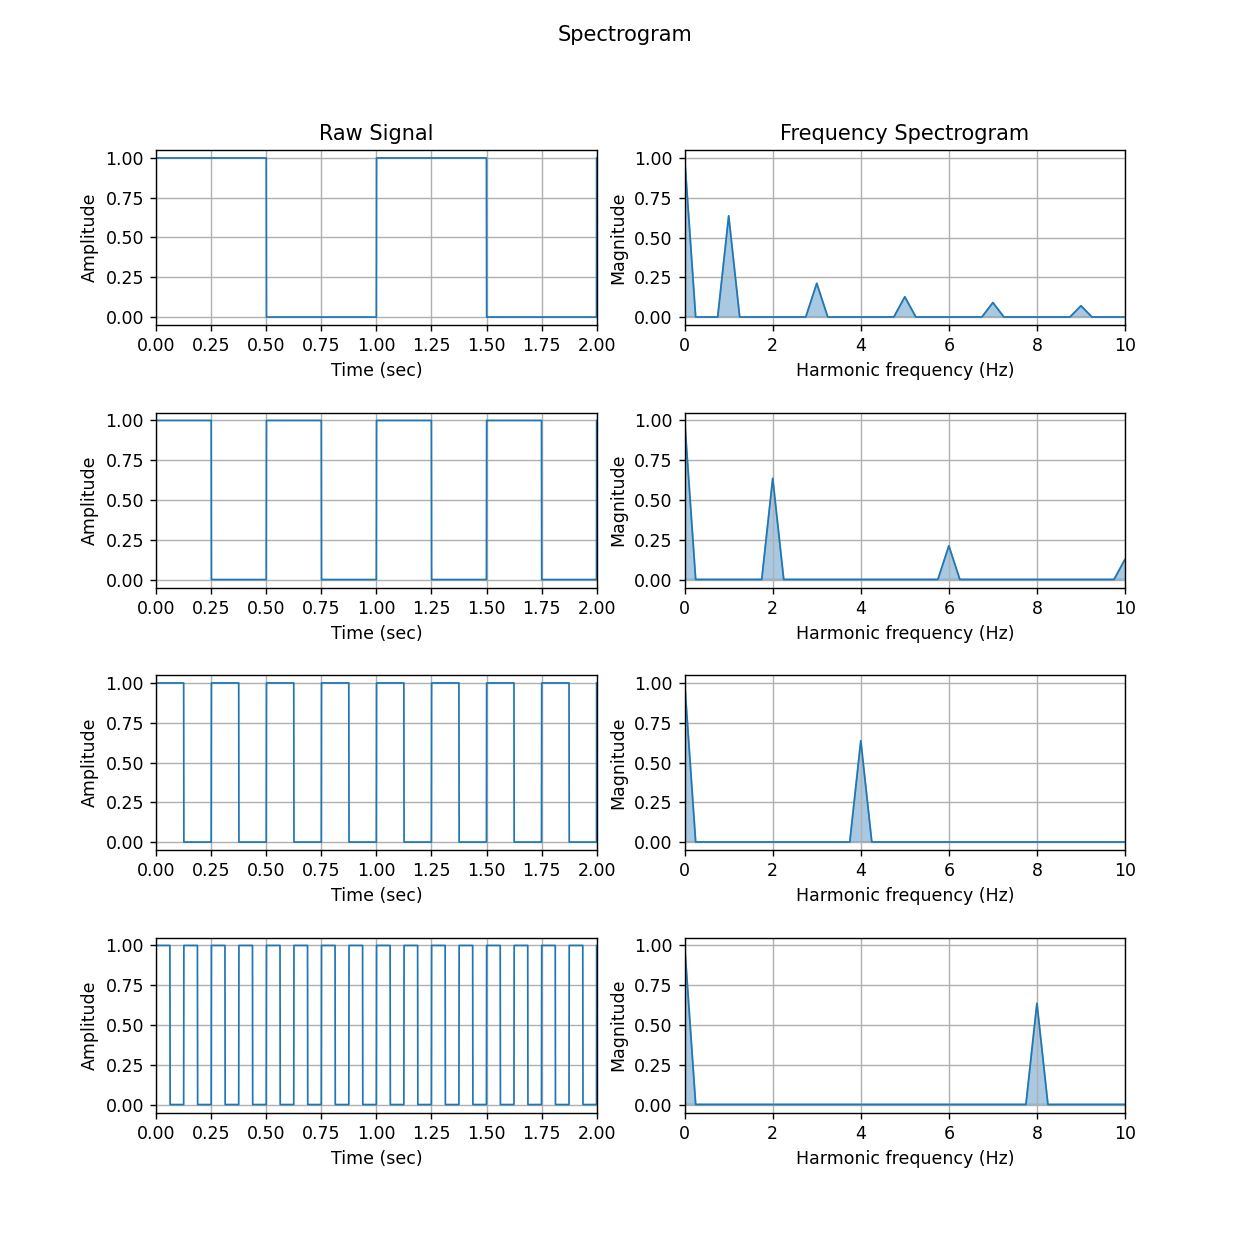

In [6]:
# Creation of figure and subplots
fig, ((afunc1, aspec1), (afunc2, aspec2), (afunc4, aspec4), (afunc8, aspec8)) = plt.subplots(figsize=(10, 10), dpi=100, nrows=4, ncols=2)
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Spectrogram')
signal_axes   = fig.axes[::2]
spectrum_axes = fig.axes[1::2]

# Setting visible intervals
xlim(signal_axes, [(0, 2)])
xlim(spectrum_axes, [(0, 10)])

# Drawing grid
grid(signal_axes)
grid(spectrum_axes)

# Setting y labels
ylabel(signal_axes, 'Amplitude')
ylabel(spectrum_axes, 'Magnitude')

# Setting x labels
xlabel(signal_axes, 'Time (sec)')
xlabel(spectrum_axes, 'Harmonic frequency (Hz)')

# Setting column titles
afunc1.set_title('Raw Signal')
aspec1.set_title('Frequency Spectrogram')

# Plotting
fill_color = (0.121, 0.464, 0.703, 0.39)

draw(signal_axes, [(xf1, yf1), (xf2, yf2), (xf4, yf4), (xf8, yf8)])
draw(spectrum_axes, [(xs1, ys1), (xs2, ys2), (xs4, ys4), (xs8, ys8)], color=fill_color, fill='in')
draw(spectrum_axes, [(xs1, ys1), (xs2, ys2), (xs4, ys4), (xs8, ys8)])